## Imports

**NOTE:** You'll need to `git clone https://github.com/dfelikson/scripts_and_utilities.git` into some directory and append the sub-directory `pythonModules` to `sys.path`. Below, you'll see that I've cloned it to `/home/jovyan/Software/scripts_and_utilities` and I append `/home/jovyan/Software/scripts_and_utilities/pythonModules` to `sys.path`.

In [1]:
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

#import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle

import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

import sys
sys.path.append('/home/jovyan/Software/scripts_and_utilities/pythonModules')
import raster

import glob


## Load the MEaSUREs velocity data

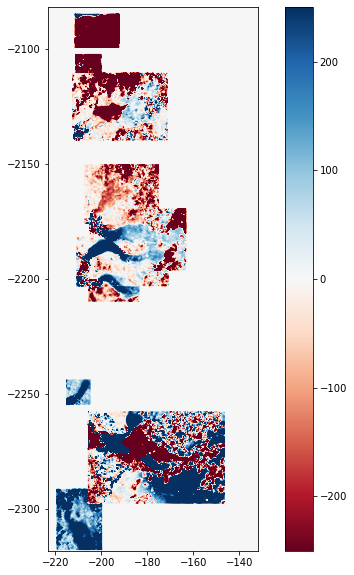

In [3]:
# 1994
vx = raster.readRasterBandAsArray('/home/jovyan/measures_vel/data/OPT_1994-07_vx_merged.tif', 1)
vy = raster.readRasterBandAsArray('/home/jovyan/measures_vel/data/OPT_1994-07_vy_merged.tif', 1)
vel_1994 = np.sqrt(vx**2 + vy**2)

vel_change_obs_gt = raster.getCoordinates('/home/jovyan/measures_vel/data/OPT_1994-07_vx_merged.tif', 1)
vel_change_obs_extent = raster.gt2extent(vx, vel_change_obs_gt)

# 2014
vx = raster.readRasterBandAsArray('/home/jovyan/measures_vel/data/OPT_2014-07_vx_merged.tif', 1)
vy = raster.readRasterBandAsArray('/home/jovyan/measures_vel/data/OPT_2014-07_vy_merged.tif', 1)
vel_2014 = np.sqrt(vx**2 + vy**2)

#vel_change_obs_gt = raster.getCoordinates('/home/jovyan/measures_vel/data/OPT_2014-07_vx_merged.tif', 1)
#vel_change_obs_extent = raster.gt2extent(vx, vel_change_obs_gt)

# Calculate the difference
vel_change_obs = vel_2014 - vel_1994

# Plot the observed velocity change
fig = plt.figure(figsize=(10,10))
plt.imshow(vel_change_obs, extent=np.array(vel_change_obs_extent)/1000., vmin=-250, vmax=250, cmap='RdBu')
plt.colorbar()


## Load the ISSM velocity

In [4]:
md = loadmodel('/efs/dfelikso/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_hindcast_EN4_RACMO_baseline.nc')

md_vel_change = md.results.TransientSolution[-1].Vel - md.results.TransientSolution[0].Vel
md_mask_ice = md.results.TransientSolution[-1].MaskIceLevelset<0


Opening /efs/dfelikso/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_hindcast_EN4_RACMO_baseline.nc for reading 
empty init


## Grid the ISSM velocity change to the MEaSUREs grid

In [5]:
from scipy.interpolate import griddata

xgrid = np.arange(vel_change_obs_extent[0], vel_change_obs_extent[1], vel_change_obs_gt[1])
ygrid = np.arange(vel_change_obs_extent[3], vel_change_obs_extent[2], vel_change_obs_gt[5])
xgrid, ygrid = np.meshgrid(xgrid, ygrid)

md_vel_change[~md_mask_ice] = np.nan

vel_change_mod = griddata((md.mesh.x,md.mesh.y), md_vel_change, (xgrid,ygrid), method='linear')


## Compare modeled and observed velocity change

**IMPORTANT NOTE:** Make sure that both the modeled and observed velocity changes are calculated over the same time span. Right now, I'm just calculating modeled velocity change from the beginning to the end of the TransientSolution, whatever that may be.

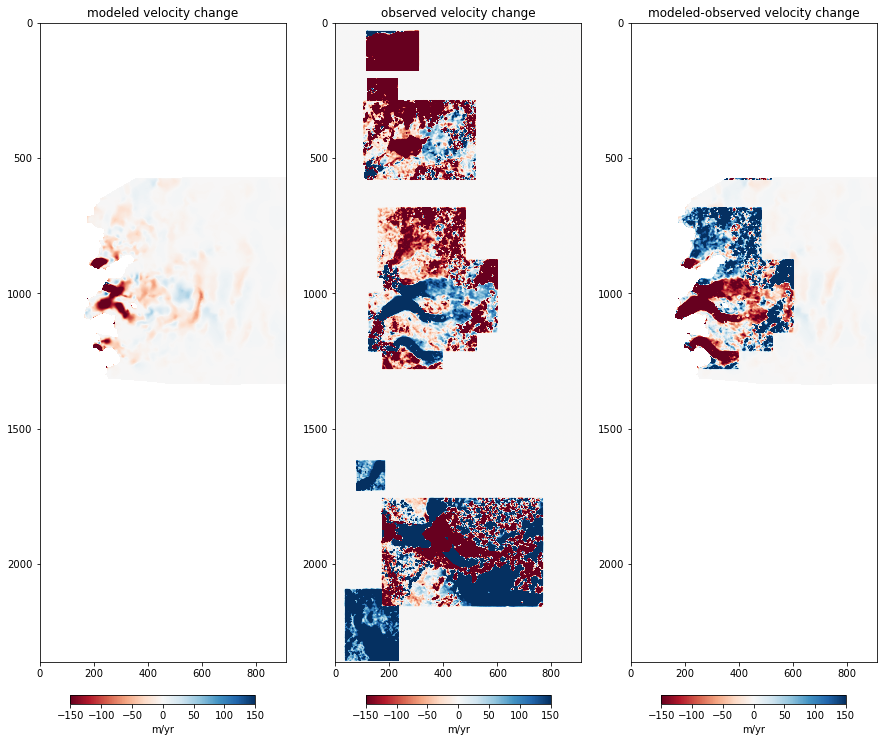

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
im0 = ax[0].imshow(vel_change_mod, cmap='RdBu', vmin=-150, vmax=+150)
im1 = ax[1].imshow(vel_change_obs, cmap='RdBu', vmin=-150, vmax=+150)
im2 = ax[2].imshow(vel_change_mod - vel_change_obs, cmap='RdBu', vmin=-150, vmax=+150)

ax[0].set_title('modeled velocity change')
ax[1].set_title('observed velocity change')
ax[2].set_title('modeled-observed velocity change')

plt.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75, pad=0.04, label='m/yr')
plt.colorbar(im1, ax=ax[1], orientation='horizontal', shrink=0.75, pad=0.04, label='m/yr')
plt.colorbar(im2, ax=ax[2], orientation='horizontal', shrink=0.75, pad=0.04, label='m/yr')
